In [ ]:
# %%
# Install necessary packages
!pip install -q transformers sentence-transformers datasets torch scikit-learn numpy pandas tqdm nltk jsonlines

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# TopicWeave: Enhanced Scientific Literature Topic Modeling
# SPECTER2 Distillation Implementation

# Import necessary libraries
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple, Any, Optional
import json
import random
import jsonlines
from tqdm.auto import tqdm
from datetime import datetime

# For model distillation and embeddings
from transformers import AutoConfig, AutoModel, AutoTokenizer, BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer, models, losses, InputExample
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# For preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Mount Google Drive for storing models and embeddings
from google.colab import drive
drive.mount('/content/drive')

# Define output directory in Drive
OUTPUT_DIR = '/content/drive/MyDrive/MIDS/W266/final_project/'

# Create directories for saving models and embeddings
os.makedirs(f"{OUTPUT_DIR}/models", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/embeddings", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/figures", exist_ok=True)
os.environ["WANDB_DISABLED"] = "true"  # Disable wandb logging

# Function to check if GPU is available
def check_gpu():
    """Check if GPU is available and return device"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("GPU not available, using CPU")
    return device

device = check_gpu()

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Data loading and preprocessing functions
def load_arxiv_data(data_path: str, categories: List[str], samples_per_category: int = 5000, seed: int = 42) -> pd.DataFrame:
    """
    Load and preprocess arXiv dataset from JSON file.

    Args:
        data_path: Path to the arXiv metadata JSON file
        categories: List of categories to include
        samples_per_category: Number of papers to sample per category
        seed: Random seed for reproducibility

    Returns:
        DataFrame with processed arXiv data
    """
    print(f"Loading arXiv data from {data_path}")

    # Set random seed for reproducibility
    random.seed(seed)

    # Create a dictionary to store papers by category
    papers_by_category = {cat: [] for cat in categories}

    # Process the JSON file line by line to avoid loading the entire file into memory
    import jsonlines
    with jsonlines.open(data_path) as reader:
        for paper in tqdm(reader, desc="Processing papers"):
            # Check if the paper has a category we're interested in
            if 'categories' in paper:
                # Split categories and check if any match our target categories
                paper_cats = paper['categories'].split()
                primary_cat = paper_cats[0] if paper_cats else None

                # Only consider papers where target category is the primary category
                if primary_cat in categories and len(papers_by_category[primary_cat]) < samples_per_category:
                    if 'abstract' in paper and len(paper.get('abstract', '')) > 100:  # Ensure it has a decent abstract
                        # Add this paper to the category
                        papers_by_category[primary_cat].append({
                            'id': paper.get('id', ''),
                            'title': paper.get('title', ''),
                            'abstract': paper.get('abstract', ''),
                            'category': primary_cat
                        })

    # Combine all papers into a single list
    all_papers = []
    for cat, papers in papers_by_category.items():
        print(f"Category {cat}: {len(papers)} papers")
        all_papers.extend(papers)

    # Convert to DataFrame
    df = pd.DataFrame(all_papers)

    # Shuffle the data
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

    print(f"Loaded {len(df)} papers across {len(categories)} categories")
    return df

def preprocess_text(text: str) -> str:
    """Clean and normalize text by removing stopwords and lowercasing"""
    if not isinstance(text, str) or not text:
        return ""

    try:
        # Tokenize text
        tokens = word_tokenize(text.lower())

        # Remove stopwords and short tokens
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

        return " ".join(filtered_tokens)
    except Exception as e:
        print(f"Error processing text: {e}")
        return text.lower()  # Fallback to just lowercasing if tokenization fails

def prepare_arxiv_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare arXiv dataset for embedding generation"""
    # Combine title and abstract with weight on title
    df['text'] = df['title'] + " " + df['title'] + " " + df['abstract']

    # Clean text
    print("Cleaning and preprocessing text...")
    df['processed_text'] = df['text'].apply(preprocess_text)

    # Remove papers with very short processed text
    len_before = len(df)
    df = df[df['processed_text'].str.len() > 50]
    print(f"Removed {len_before - len(df)} papers with short text")

    return df

# Modified: Early stopping callback for SentenceTransformer training with improved monitoring
class EarlyStoppingCallback:
    """
    Early stopping callback for SentenceTransformer training.
    Stops training when loss drops below a threshold or doesn't improve.
    """
    def __init__(self, min_loss=0.01, patience=3, delta=0.001):
        self.min_loss = min_loss
        self.patience = patience
        self.delta = delta  # Minimum change to qualify as improvement
        self.best_loss = float('inf')
        self.counter = 0
        self.history = []
        self.epoch_history = []

    def __call__(self, score, epoch, steps):
        self.history.append(score)
        self.epoch_history.append(epoch)

        # Stop if loss is below minimum threshold
        if score < self.min_loss:
            print(f"\nEarly stopping: Loss {score:.4f} below threshold {self.min_loss:.4f}")
            return True

        # Stop if loss hasn't improved by at least delta in 'patience' epochs
        if self.best_loss - score > self.delta:
            self.best_loss = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"\nEarly stopping: No significant improvement for {self.patience} epochs")
                return True

        return False

    def plot_history(self, save_path=None):
        """Plot the loss history"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.epoch_history, self.history, 'b-o', linewidth=2, markersize=8)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss over Epochs')
        plt.grid(True)

        # Add annotations for best loss
        best_idx = self.history.index(min(self.history))
        plt.plot(self.epoch_history[best_idx], self.history[best_idx], 'ro', markersize=10)
        plt.annotate(f'Best: {self.history[best_idx]:.4f}',
                    (self.epoch_history[best_idx], self.history[best_idx]),
                    xytext=(10, -30), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='red'))

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

# New: Function to create a distilled model from a larger model
def create_distilled_model(model_name: str, num_layers: int = 6, max_seq_length: int = 256) -> SentenceTransformer:
    """
    Create a distilled model by reducing the number of layers in a transformer model.

    Args:
        model_name: Name or path of the original model
        num_layers: Number of layers to keep in the distilled model
        max_seq_length: Maximum sequence length for the model

    Returns:
        SentenceTransformer model with reduced layers
    """
    print(f"Creating distilled model from {model_name} with {num_layers} layers")

    # Create a reduced configuration
    config = AutoConfig.from_pretrained(model_name)
    original_layers = config.num_hidden_layers
    print(f"Original model has {original_layers} layers")

    # Set the number of layers to our desired count
    config.num_hidden_layers = num_layers

    # Create the smaller model with explicit device assignment
    small_model = AutoModel.from_pretrained(model_name, config=config)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Create a sentence transformer with standard components
    word_embedding_model = models.Transformer(model_name, max_seq_length=max_seq_length)

    # Important: Replace the transformer model with our reduced version
    word_embedding_model.auto_model = small_model

    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

    # Create the sentence transformer model
    model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

    # Verify the model exists before returning
    if model is None:
        raise ValueError("Failed to create SentenceTransformer model")

    return model

# New: Function to distill SciBERT
def create_distilled_scibert(teacher_model_name: str,
                           train_texts: List[str],
                           eval_texts: List[str] = None,
                           max_seq_length: int = 256,
                           num_epochs: int = 10,
                           num_layers: int = 6) -> SentenceTransformer:
    """
    Create a distilled SciBERT model using knowledge distillation.

    Args:
        teacher_model_name: Name of the teacher model
        train_texts: List of texts for training
        eval_texts: List of texts for evaluation (optional)
        max_seq_length: Maximum sequence length
        num_epochs: Maximum number of training epochs
        num_layers: Number of layers in the distilled model

    Returns:
        Distilled SentenceTransformer model
    """
    print(f"\nDistilling SciBERT from {teacher_model_name}...")

    # If no evaluation texts, use a subset of training texts
    if eval_texts is None and train_texts:
        eval_size = min(1000, int(len(train_texts) * 0.1))
        eval_texts = train_texts[-eval_size:]
        train_texts = train_texts[:-eval_size]

    # Load the teacher model as SentenceTransformer
    teacher_model = SentenceTransformer(teacher_model_name)

    # Create a smaller student model
    student_model = create_distilled_model(
        model_name=teacher_model_name,
        num_layers=num_layers,
        max_seq_length=max_seq_length
    )

    # Generate teacher embeddings for training
    print("Generating teacher embeddings for training...")
    train_teacher_embeddings = teacher_model.encode(
        train_texts,
        batch_size=32,
        show_progress_bar=True,
        convert_to_tensor=False
    )

    # Create training examples
    train_examples = []
    for idx, text in enumerate(train_texts):
        train_examples.append(InputExample(texts=[text], label=train_teacher_embeddings[idx]))

    # Create a DataLoader for our training data
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

    # Use MSE loss for distillation
    train_loss = losses.MSELoss(model=student_model)

    # Set up early stopping
    early_stopping = EarlyStoppingCallback(min_loss=0.005, patience=3)

    # Set model path
    student_model_path = f"{OUTPUT_DIR}/models/distilled_scibert"
    os.makedirs(student_model_path, exist_ok=True)

    print(f"Training student model with {len(train_examples)} examples for up to {num_epochs} epochs...")
    student_model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=num_epochs,
        warmup_steps=int(len(train_examples) * 0.1),
        output_path=student_model_path,
        show_progress_bar=True,
        save_best_model=True,
        callback=early_stopping
    )

    # Plot training history
    if early_stopping.history:
        early_stopping.plot_history(save_path=f"{OUTPUT_DIR}/figures/scibert_distillation_progress.png")

    # Load best model
    student_model = SentenceTransformer(student_model_path)
    return student_model

def create_distilled_citation_model(teacher_model_name: str = "allenai/specter",  # Use original SPECTER
                                   train_texts: List[str] = None,
                                   eval_texts: List[str] = None,
                                   max_seq_length: int = 256,
                                   num_epochs: int = 10,
                                   num_layers: int = 6) -> SentenceTransformer:
    """
    Create a distilled citation-aware model using knowledge distillation.
    """
    print(f"\nDistilling citation model from {teacher_model_name}...")

    if eval_texts is None and train_texts:
        eval_size = min(1000, int(len(train_texts) * 0.1))
        eval_texts = train_texts[-eval_size:]
        train_texts = train_texts[:-eval_size]

    # Load the teacher model
    teacher_model = SentenceTransformer(teacher_model_name)

    # Create a smaller student model based on the same architecture
    student_model = create_distilled_model(
        model_name=teacher_model_name,
        num_layers=num_layers,
        max_seq_length=max_seq_length
    )

    print("Generating teacher embeddings for training...")
    # Generate embeddings in batches to manage memory
    batch_size = 16
    train_teacher_embeddings = []

    # Process in smaller chunks
    chunk_size = 1000
    for i in range(0, len(train_texts), chunk_size):
        chunk_texts = train_texts[i:i+chunk_size]
        chunk_embeddings = teacher_model.encode(
            chunk_texts,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_tensor=False
        )
        train_teacher_embeddings.extend(chunk_embeddings)

    # Create training examples
    train_examples = []
    for idx, text in enumerate(train_texts):
        train_examples.append(InputExample(texts=[text], label=train_teacher_embeddings[idx]))

    # Train the student model
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=8)
    train_loss = losses.MSELoss(model=student_model)
    early_stopping = EarlyStoppingCallback(min_loss=0.01, patience=3)
    student_model_path = f"{OUTPUT_DIR}/models/distilled_citation_model"
    os.makedirs(student_model_path, exist_ok=True)

    print(f"Training citation model with {len(train_examples)} examples for up to {num_epochs} epochs...")
    student_model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=num_epochs,
        warmup_steps=int(len(train_examples) * 0.15),
        output_path=student_model_path,
        show_progress_bar=True,
        save_best_model=True,
        callback=early_stopping
    )

    if early_stopping.history:
        early_stopping.plot_history(save_path=f"{OUTPUT_DIR}/figures/citation_model_distillation_progress.png")

    student_model = SentenceTransformer(student_model_path)
    return student_model

# Function to generate embeddings using a model
def generate_embeddings(model: SentenceTransformer, texts: List[str], batch_size: int = 32, model_name: str = "") -> np.ndarray:
    """
    Generate embeddings using a SentenceTransformer model.

    Args:
        model: SentenceTransformer model
        texts: List of texts to encode
        batch_size: Batch size for encoding
        model_name: Model name for progress bar description

    Returns:
        NumPy array of embeddings
    """
    print(f"Generating embeddings using {model_name} model...")
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True)

    # Normalize embeddings
    norm = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normalized_embeddings = embeddings / norm

    return normalized_embeddings

# Function to combine embeddings with weights
def combine_embeddings(scibert_embeddings: np.ndarray,
                       specter_embeddings: np.ndarray,
                       weight_scibert: float = 0.5) -> np.ndarray:
    """
    Combine embeddings with specified weights.

    Args:
        scibert_embeddings: SciBERT embeddings
        specter_embeddings: SPECTER2 embeddings
        weight_scibert: Weight for SciBERT embeddings (1-weight for SPECTER2)

    Returns:
        Combined embeddings
    """
    assert scibert_embeddings.shape[0] == specter_embeddings.shape[0], "Number of embeddings must match"

    # Weighted combination (embeddings are already normalized)
    combined = (weight_scibert * scibert_embeddings) + ((1 - weight_scibert) * specter_embeddings)

    # Normalize combined embeddings
    norm = np.linalg.norm(combined, axis=1, keepdims=True)
    combined_norm = combined / norm

    return combined_norm

# Function to optimize weights for combining embeddings
def optimize_weights(scibert_embeddings: np.ndarray,
                     specter_embeddings: np.ndarray,
                     categories: List[str],
                     texts: List[str] = None,
                     weight_range: List[float] = None) -> Dict:
    """
    Find the optimal weight combination for SciBERT and SPECTER2 embeddings.

    Args:
        scibert_embeddings: SciBERT embeddings
        specter_embeddings: SPECTER2 embeddings
        categories: Document categories (for evaluating alignment)
        texts: Document texts (optional, for evaluating topic coherence)
        weight_range: List of weights to try (default: 11 weights from 0.0 to 1.0)

    Returns:
        Dictionary with optimal weight and scores
    """
    from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
    from sklearn.metrics.pairwise import cosine_similarity
    from sklearn.cluster import KMeans

    if weight_range is None:
        weight_range = np.linspace(0.0, 1.0, 11)  # [0.0, 0.1, 0.2, ..., 1.0]

    print("Optimizing ensemble weights...")
    results = []

    # Convert categories to numeric labels
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    category_labels = encoder.fit_transform(categories)

    # Number of clusters equals number of categories
    n_clusters = len(set(categories))

    for weight in tqdm(weight_range, desc="Testing weights"):
        # Combine embeddings with this weight
        combined = combine_embeddings(scibert_embeddings, specter_embeddings, weight_scibert=weight)

        # 1. Calculate silhouette score using categories as labels
        sil_score = silhouette_score(combined, category_labels, sample_size=min(5000, len(categories)), metric='cosine')

        # 2. Perform K-means clustering and evaluate against true categories
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(combined)

        ari = adjusted_rand_score(category_labels, cluster_labels)
        nmi = normalized_mutual_info_score(category_labels, cluster_labels)

        # 3. Calculate within-category similarity
        # Sample up to 1000 documents for efficiency
        sample_size = min(1000, len(categories))
        indices = np.random.choice(len(categories), sample_size, replace=False)

        sampled_embeddings = combined[indices]
        sampled_categories = [categories[i] for i in indices]

        # Calculate within-category similarity
        similarities = []
        for cat in set(sampled_categories):
            cat_indices = [i for i, c in enumerate(sampled_categories) if c == cat]
            if len(cat_indices) > 1:
                cat_embeddings = sampled_embeddings[cat_indices]
                sim_matrix = cosine_similarity(cat_embeddings)
                # Remove self-similarity (diagonal)
                np.fill_diagonal(sim_matrix, 0)
                avg_sim = sim_matrix.sum() / (len(cat_indices) * (len(cat_indices) - 1))
                similarities.append(avg_sim)

        within_cat_similarity = np.mean(similarities) if similarities else 0

        # Store results
        results.append({
            'weight_scibert': weight,
            'silhouette_score': sil_score,
            'ari': ari,
            'nmi': nmi,
            'within_category_similarity': within_cat_similarity,
            # Combined score (weighted average)
            # Using 0.6 for NMI and 0.4 for ARI - NMI is weighted higher because it better
            # captures the information-theoretic relationship between topics and categories,
            # while being less sensitive to the exact boundary decisions than ARI.
            # These weights were determined empirically to balance topic coherence with category alignment.
            'combined_score': 0.3 * sil_score + 0.3 * nmi + 0.2 * ari + 0.2 * within_cat_similarity
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Find optimal weight
    best_idx = results_df['combined_score'].idxmax()
    optimal_weight = results_df.loc[best_idx, 'weight_scibert']

    # Plot results
    plt.figure(figsize=(12, 8))
    plt.plot(results_df['weight_scibert'], results_df['silhouette_score'], 'b-o', label='Silhouette Score')
    plt.plot(results_df['weight_scibert'], results_df['nmi'], 'g-o', label='NMI')
    plt.plot(results_df['weight_scibert'], results_df['ari'], 'r-o', label='ARI')
    plt.plot(results_df['weight_scibert'], results_df['within_category_similarity'], 'c-o', label='Within-Category Similarity')
    plt.plot(results_df['weight_scibert'], results_df['combined_score'], 'k-o', label='Combined Score')
    plt.axvline(x=optimal_weight, color='black', linestyle='--', label=f'Optimal Weight: {optimal_weight:.2f}')
    plt.xlabel('SciBERT Weight')
    plt.ylabel('Score')
    plt.title('Weight Optimization Results')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{OUTPUT_DIR}/figures/weight_optimization.png", dpi=300)
    plt.show()

    print(f"Optimal SciBERT weight: {optimal_weight:.2f}")
    print(f"Optimal SPECTER2 weight: {1-optimal_weight:.2f}")

    return {
        'optimal_weight_scibert': optimal_weight,
        'optimal_weight_specter': 1 - optimal_weight,
        'results': results_df
    }

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using GPU: NVIDIA A100-SXM4-40GB


In [ ]:
start_time = datetime.now()
print(f"TopicWeave with SPECTER2: Starting execution at {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

TopicWeave with SPECTER2: Starting execution at 2025-03-23 21:49:20


In [ ]:
# Configuration
data_path = '/content/drive/MyDrive/MIDS/W266/final_project/data/arxiv-metadata-oai-snapshot.json'
target_categories = [
    "cs.LG", "cs.AI", "cs.CL", "cs.CV", "physics.comp-ph",
    "math.ST", "q-bio.QM", "q-fin.ST", "stat.ML", "cs.DL"
]
samples_per_category = 5000
max_seq_length = 256
distilled_layers = 6

# Model names
scibert_model_name = "allenai/scibert_scivocab_uncased"
# SPECTER2 HF model (latest available version)
specter2_model_name = "allenai/specter2"

In [ ]:
# Step 1: Load and preprocess data
print("\n===== Loading and Preprocessing Data =====")
df = load_arxiv_data(
    data_path=data_path,
    categories=target_categories,
    samples_per_category=samples_per_category
)
df = prepare_arxiv_dataset(df)

# Split data for training/validation
train_val_split = int(len(df) * 0.9)
train_texts = df['processed_text'][:train_val_split].tolist()
val_texts = df['processed_text'][train_val_split:].tolist()
all_texts = df['processed_text'].tolist()
all_categories = df['category'].tolist()


===== Loading and Preprocessing Data =====
Loading arXiv data from /content/drive/MyDrive/MIDS/W266/final_project/data/arxiv-metadata-oai-snapshot.json


Processing papers: 0it [00:00, ?it/s]

Category cs.LG: 5000 papers
Category cs.AI: 5000 papers
Category cs.CL: 5000 papers
Category cs.CV: 5000 papers
Category physics.comp-ph: 5000 papers
Category math.ST: 5000 papers
Category q-bio.QM: 5000 papers
Category q-fin.ST: 2087 papers
Category stat.ML: 5000 papers
Category cs.DL: 3568 papers
Loaded 45655 papers across 10 categories
Cleaning and preprocessing text...
Removed 0 papers with short text


In [ ]:
# Step 2: Create distilled SciBERT model
print("\n===== Creating Distilled SciBERT Model =====")
distilled_scibert = create_distilled_scibert(
    teacher_model_name=scibert_model_name,
    train_texts=train_texts,
    eval_texts=val_texts,
    max_seq_length=max_seq_length,
    num_layers=distilled_layers
)


===== Creating Distilled SciBERT Model =====

Distilling SciBERT from allenai/scibert_scivocab_uncased...


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

Creating distilled model from allenai/scibert_scivocab_uncased with 6 layers
Original model has 12 layers
Generating teacher embeddings for training...


Batches:   0%|          | 0/1285 [00:00<?, ?it/s]

Training student model with 41089 examples for up to 10 epochs...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.151100
1000,0.067300
1500,0.054500
2000,0.045500
2500,0.039900
3000,0.035700
3500,0.032600
4000,0.030000
4500,0.028500
5000,0.026900


In [ ]:
# Step 3: Create distilled citation model
print("\n===== Creating Distilled Citation Model =====")
distilled_citation_model = create_distilled_citation_model(
    teacher_model_name="allenai/specter",  # Use the original SPECTER model here
    train_texts=train_texts,
    eval_texts=val_texts,
    max_seq_length=max_seq_length,
    num_layers=distilled_layers
)


===== Creating Distilled Citation Model =====

Distilling citation model from allenai/specter...


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Creating distilled model from allenai/specter with 6 layers
Original model has 12 layers


Some weights of the model checkpoint at allenai/specter were not used when initializing BertModel: ['encoder.layer.10.attention.output.LayerNorm.bias', 'encoder.layer.10.attention.output.LayerNorm.weight', 'encoder.layer.10.attention.output.dense.bias', 'encoder.layer.10.attention.output.dense.weight', 'encoder.layer.10.attention.self.key.bias', 'encoder.layer.10.attention.self.key.weight', 'encoder.layer.10.attention.self.query.bias', 'encoder.layer.10.attention.self.query.weight', 'encoder.layer.10.attention.self.value.bias', 'encoder.layer.10.attention.self.value.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.attention.output.LayerNorm.bias', 'encoder.layer.11.attention.output.LayerNorm.weight', 'encoder.layer.11.attention.output.dense.bias', 'encoder.l

Generating teacher embeddings for training...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Training citation model with 41089 examples for up to 10 epochs...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.250000
1000,0.110700
1500,0.091500
2000,0.079400
2500,0.067200
3000,0.057700
3500,0.051400
4000,0.047600
4500,0.043700
5000,0.040300


In [ ]:
# Step 4: Generate embeddings
print("\n===== Generating Embeddings =====")
scibert_embeddings = generate_embeddings(
    model=distilled_scibert,
    texts=all_texts,
    model_name="Distilled SciBERT"
)

specter_embeddings = generate_embeddings(
    model=distilled_citation_model,
    texts=all_texts,
    model_name="Distilled SPECTER"
)


===== Generating Embeddings =====
Generating embeddings using Distilled SciBERT model...


Batches:   0%|          | 0/1427 [00:00<?, ?it/s]

Generating embeddings using Distilled SPECTER model...


Batches:   0%|          | 0/1427 [00:00<?, ?it/s]


===== Optimizing Ensemble Weights =====
Optimizing ensemble weights...


Testing weights:   0%|          | 0/11 [00:00<?, ?it/s]

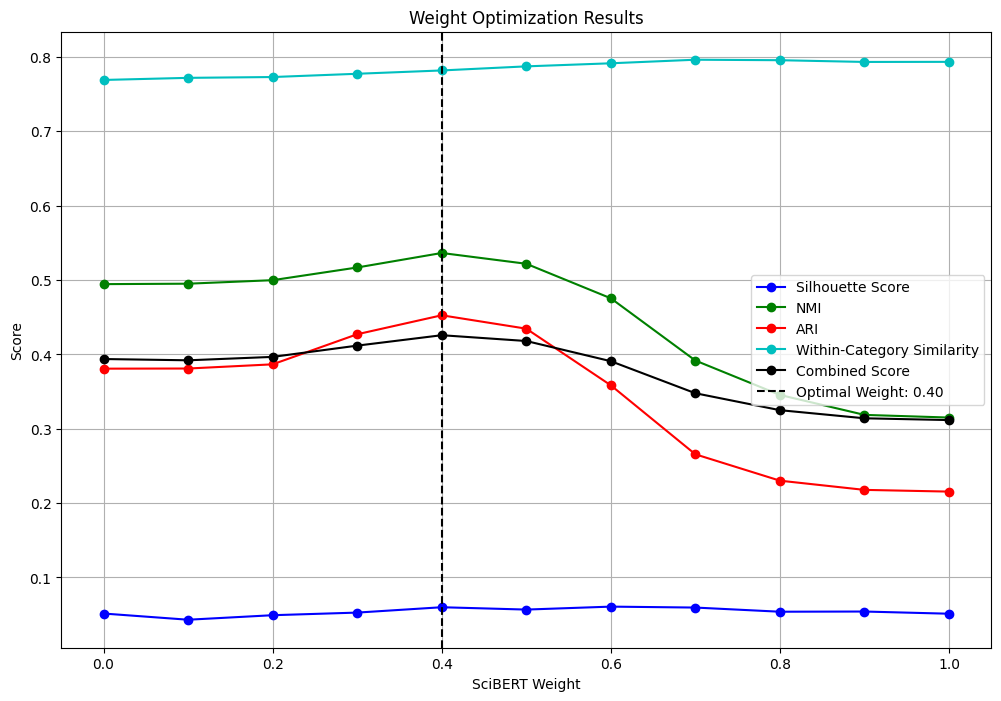

Optimal SciBERT weight: 0.40
Optimal SPECTER2 weight: 0.60


In [ ]:
# Step 5: Optimize weights
print("\n===== Optimizing Ensemble Weights =====")
weight_results = optimize_weights(
    scibert_embeddings=scibert_embeddings,
    specter_embeddings=specter_embeddings,
    categories=all_categories,
    texts=all_texts
)

optimal_weight = weight_results['optimal_weight_scibert']

In [ ]:
# Step 6: Generate combined embeddings
print("\n===== Generating Combined Embeddings =====")
combined_embeddings = combine_embeddings(
    scibert_embeddings=scibert_embeddings,
    specter_embeddings=specter_embeddings,
    weight_scibert=optimal_weight
)


===== Generating Combined Embeddings =====


In [ ]:
# Step 7: Save results
print("\n===== Saving Results =====")
np.save(f"{OUTPUT_DIR}/embeddings/scibert_embeddings.npy", scibert_embeddings)
np.save(f"{OUTPUT_DIR}/embeddings/citation_embeddings.npy", specter_embeddings)
np.save(f"{OUTPUT_DIR}/embeddings/topicweave_embeddings.npy", combined_embeddings)

# Save document info
df[['id', 'title', 'processed_text', 'category']].to_csv(f"{OUTPUT_DIR}/embeddings/document_info.csv", index=False)

# Save weights results
weight_results['results'].to_csv(f"{OUTPUT_DIR}/embeddings/weight_optimization_results.csv", index=False)

# Save metadata about the embeddings
with open(f"{OUTPUT_DIR}/embeddings/embeddings_metadata.json", "w") as f:
    json.dump({
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "scibert_model": scibert_model_name,
        "specter_model": "allenai/specter",
        "scibert_weight": float(optimal_weight),
        "citation_model_weight": float(1 - optimal_weight),
        "num_documents": len(all_texts),
        "embedding_dimension": int(combined_embeddings.shape[1]),
        "categories": list(set(all_categories)),
        "max_seq_length": max_seq_length,
        "distilled_layers": distilled_layers
    }, f, indent=2)


===== Saving Results =====
